在 A* 搜索过程中，节点具有多个属性，为了更方便的描述一个节点，我们可以创建一个结构体来存储一个节点的多个属性。

In [6]:
class Node:
    def __init__(
        self, 
        position: tuple, 
        g: float, 
        f: float, 
        parent: 'Node'
        ) -> None:
        
        self.position = position
        self.g = g
        self.f = f
        self.parent_node = parent

在这段代码中，我们展示了如何使用 A*（A-star）路径规划算法在给定的地图中找到一条从起点到终点的路径。首先，我们定义了 `Node` 类来表示地图中的一个点，包括它的位置、从起点到该点的实际距离 $g$、从该点到终点的预计距离 $h$（估值函数），以及该点的父节点。

然后我们创建了 AStar 类来实现 A* 算法。在初始化时，我们将地图和起点、终点的坐标保存下来，并设置一些参数，如每步移动的距离和搜索范围。然后，我们定义了 `search_path`、`retrieve_path` 和 `update_planning` 等方法来完成路径的搜索和获取。

在 `search_path` 方法中，我们使用 A* 算法来搜索路径。我们首先将起点添加到关闭列表中，然后在每一步中，我们都从开放列表中选取 f 值最小的节点作为当前节点，然后考虑该节点的所有相邻节点。对于每一个相邻节点，我们计算其 g 值和 h 值，并更新其 f 值和父节点。然后将其添加到开放列表中。这个过程一直重复，直到终点被加入到关闭列表中，或者开放列表为空（表示无法到达终点）。

在 `retrieve_path` 方法中，我们从终点开始，通过每个节点的父节点回溯，直到回到起点，从而获得了从起点到终点的路径。

在 `update_planning` 方法中，我们首先调用 `search_path` 方法搜索路径，然后调用 `retrieve_path` 方法获取路径，并将其保存下来。

In [7]:
import math
import cv2
import numpy as np

class AStar:
    def __init__(
        self, 
        start_x: int, 
        start_y: int, 
        end_x  : int, 
        end_y  : int,
        map_image: np.ndarray,
        step_size    = 5,
        search_range = 40, 
        scale = 5
        ) -> None:
        
        self.start_x_   = start_x // scale
        self.start_y_   = start_y // scale
        self.end_x_     = end_x   // scale
        self.end_y_     = end_y   // scale
        self.scale_     = scale
        
        resize_height   = map_image.shape[0] // scale
        resize_width    = map_image.shape[1] // scale
        self.map_image_ = cv2.resize(map_image, (resize_width, resize_height))
        
        self.step_size_    = step_size
        self.search_range_ = search_range
        
    def search_path(self):
        start_node = Node((self.start_x_, self.start_y_), 0       , 0       , None)
        end_node   = Node((self.end_x_  , self.end_y_ ) , math.inf, math.inf, None)

        open_list = []
        close_list = [start_node]
        
        step_size = self.step_size_
        map_image = self.map_image_
        
        map_height = map_image.shape[0]
        map_width  = map_image.shape[1]
        
        while 1:
            current_node = close_list[-1]
            
            possible_moves = (
                [ 0        ,  step_size], 
                [ 0        , -step_size], 
                [ step_size,  0        ], 
                [-step_size,  0        ]
                )
            
            for move in possible_moves:
                g_cost = current_node.g + 1
                x = current_node.position[0] + move[0]
                if x < 0 or x >= map_width:
                    continue
                y = current_node.position[1] + move[1]
                if y < 0 or y >= map_height:
                    continue
                if map_image[y][x] == 0:
                    continue
                h_cost = abs(x - end_node.position[0]) + abs(y - end_node.position[1])
                f_cost = g_cost + h_cost

                if h_cost < self.search_range_:
                    step_size = 1
                new_node = Node((x, y), g_cost, f_cost, current_node)
                count = 0
                for node in open_list:
                    if node.position == new_node.position:
                        count += 1
                        if node.f > new_node.f:
                            node.g = new_node.g
                            node.f = new_node.f
                            node.parent_node = current_node
                for node in close_list:
                    if node.position == new_node.position:
                        count += 1
                if count == 0:
                    open_list.append(new_node)

            temp_node = None
                
            for i in range(len(open_list)):
                if temp_node is None or open_list[i].f < temp_node.f:
                    temp_node = open_list[i]
            
            if temp_node is None:
                print('No path found to the destination.')
                return []  
            
            for i in range(len(open_list)):
                if temp_node == open_list[i]:
                    open_list.pop(i)
                    break
            close_list.append(temp_node)
            
            if temp_node.position == end_node.position:
                print('End point found')
                break
        return close_list

    def retrieve_path(self, close_list):
        start_node_position = (self.start_x_, self.start_y_)
        path = []
        path.append(close_list[-1])
        point = path[-1]

        while 1:
            for node in close_list:
                if node.position == (point.parent_node.position if point.parent_node else None):
                    point = node
                    path.append(point)
            if point.position == start_node_position:
                print('Path search completed')
                break       
        return path 
    
    def update_planning(self):
        close_list = self.search_path()
        
        if close_list == []:
            return []
        
        path = self.retrieve_path(close_list)

        resize_path = []
        for node in path:
            resize_path.append((node.position[0] * self.scale_,
                                node.position[1] * self.scale_))
        
        return resize_path

在主函数中，我们首先读取地图，然后创建一个 `AStar` 对象，设置起点和终点的坐标，然后调用 `update_planning` 方法来搜索路径。最后，我们将搜索到的路径在地图上绘制出来。

Start planning
End point found
Path search completed


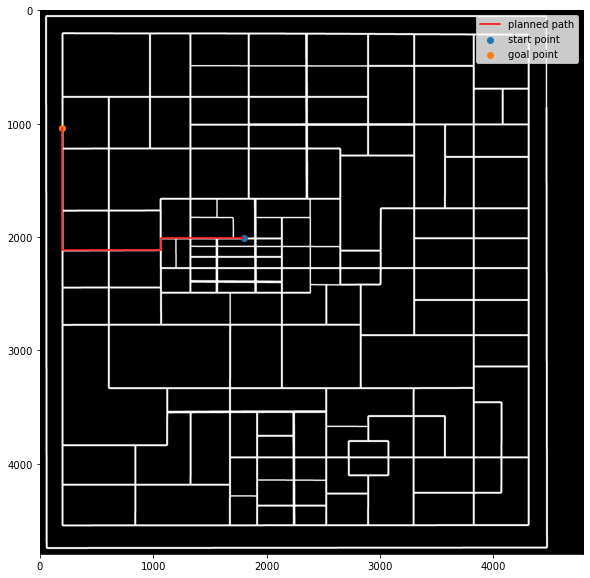

In [12]:
import matplotlib.pyplot as plt

def plot_map_and_path(map_image, path):
    plt.figure(figsize=(10, 10))
    plt.imshow(map_image, cmap='gray')
    if path is not None:
        path = np.array(path)
        plt.plot(path[:, 0], path[:, 1], 'r-', label='planned path')  
        plt.scatter(path[0, 0], path[0, 1], label='start point')
        plt.scatter(path[-1, 0], path[-1, 1], label='goal point')
    
    plt.legend()
    plt.show()

print('Start planning')
map_image = cv2.imread("./data/roadnet.png", cv2.IMREAD_GRAYSCALE)

start_x = 198
start_y = 1037
end_x   = 1800
end_y   = 2010

a_star_planner = AStar(start_x, start_y, end_x, end_y, map_image)
path = a_star_planner.update_planning()
plot_map_and_path(map_image, path)